<a href="https://colab.research.google.com/github/devparikh0506/DATA-602/blob/main/week_6/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
For the below problems, use the `MNIST_784` data set from OpenML.  Prior to using the data, scale the data and split into a test and training dataset.  The first 60,000 images are available to use as training data, and the remaining 10,000 images as test data.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#fetch OpenML data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

#split into test/validation/training sets
train_bound = slice(0, 10_000)
val_bound = slice(10_000,20_000)
test_bound = slice(60_000, None)
partition = lambda X, y, slc: (X[slc], y[slc])
X_train, y_train = partition(X, y, train_bound)
X_val, y_val = partition(X, y, val_bound)
X_test, y_test = partition(X, y, test_bound)

## Problem 1: Validation curves (10 pts)

To evaluate the performance of four candidate models performance, you produce the validation curves shown in the problem set (PDF file).
For each model, supposing you want an $R^2$ score of 0.9 or above, would you: (a) acquire more data points, (b) increase the complexity of the model or replace with a more complex model, (c) decrease the complexity of the model, or (d) accept the model?
You can indicate more than one approach.  Explain your reasoning.

(Your response here.  No code is required for this problem.)

## Problem 2: Learning curves (5 pts)

You are evaluating a complexity hyperparameter $C$ on a candidate model, and produce the learning curve shown
in the accompanying PDF file. Given this curve, what is the optimal setting for this parameter?  Why does accuracy, as measured by the $R^2$ score, decrease if the parameter is set outside this range?

(Your response here.  No code is required for this problem.)

## Problem 3: Dimensionality Reduction (30 pts)
Scale the training dataset.  Using principal component analysis (PCA), reduce the dimensionality of the training images to include 75\% of the original variance.  How many components remain following the dimensionality reduction?  Finally, apply the scaling and PCA transformations to the validation and test datasets.

In [26]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Since we know the min and max bounds for training data its good to use MinMaxScaler
mm_scaler = MinMaxScaler()

# For PCA using n_components equals to 0.75
pca = PCA(n_components=0.75)

# Using pipeline to apply scaler and PCA
pipe = Pipeline(steps=[('scale', mm_scaler), ('pca', pca)])

In [27]:
X_train_pca = pipe.fit_transform(X_train)
print(f"shape of training dataset before PCA: {X_train.shape}")
print(f"shape of training dataset after PCA: {X_train_pca.shape}")

shape of training dataset before PCA: (10000, 784)
shape of training dataset after PCA: (10000, 33)


So we now have 33 features remaining after PCA

Now let's apply scaling and PCA to validation and test datasets

In [28]:
X_val_pca = pipe.transform(X_val)
X_test_pca = pipe.transform(X_test)

# Problem 4: Support Vector Machines (50 pts)

Using the dimensionality-reduced dataset from the previous problem, train a support vector machine to classify whether a digit is less than 5 (i.e., $y \in \left\{0, 1, 2, 3, 4\right\}$).  Find a set of hyperparameters, to include the kernel function and $C$, that maximize the $F_1$ score.  The best-performing model should have an $F_1$ score of at least 0.93.

Notes:
* You may want to initially search $C$ over several orders of magnitude.  Consider initially searching with \texttt{np.logspace}.
* The hyperparameter selection may take a long time to run.  If using Google Colab, you may want to save or print the model so the work is not lost if the model reconnects.  See [Scikit-learn documentation](https://scikit-learn.org/stable/modules/model_persistence.html) for details.
* As noted in class, the `LinearSVC` class is more efficient than `SVC(kernel='linear')` for a linear SVC.

Let's first convert y_train, y_test and y_val to binary form in which 1
represents that digit is less than 5 and 0 represents that digit is greater than or equals to 5.

In [37]:
y_train_final = (y_train.astype(int) < 5).astype(int)
y_val_final = (y_val.astype(int) < 5).astype(int)
y_test_final = (y_test.astype(int) < 5).astype(int)

In [70]:
!pip install joblib

In [65]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import joblib
# Gridsearchcv params
param_grid = [
    {
        'svc' : [LinearSVC()],
        'svc__C': np.logspace(-3, 3, 7)
    },
    {
      'svc': [SVC()],
      'svc__C': np.logspace(-3, 3, 7),
      'svc__kernel': ['poly', 'rbf']
    }
    ]

pipe = Pipeline(steps=[('svc', SVC())])
clf = GridSearchCV(
    pipe, param_grid, cv=3, verbose=2, scoring='f1', n_jobs=-1
)
clf = clf.fit(X_train_pca, y_train_final)


# saving model using joblib
joblib.dump(clf, 'model.joblib')

Fitting 3 folds for each of 21 candidates, totalling 63 fits
Best estimator found using GridSearchCV Pipeline(steps=[('svc', SVC(C=10.0))])


In [67]:
print(f"Best estimator found using GridSearchCV : {clf.best_estimator_} \nParams: {clf.best_params_}")

Best estimator found using GridSearchCV : Pipeline(steps=[('svc', SVC(C=10.0))]) 
Params: {'svc': SVC(), 'svc__C': 10.0, 'svc__kernel': 'rbf'}


In [66]:
print("Best estimator score found using GridSearchCV",clf.best_score_)

Best estimator score found using GridSearchCV 0.975224338250837


In [71]:
# Loading the saved model
model = joblib.load('model.joblib')

# Problem 3: Evaluation (20 pts)
Using the best estimator you found in the previous problem, print the confusion matrix and F1 score.  You may use cross-validation methods (e.g., `cross_val_predict`) or the validation hold-out set for this problem; however, you should not yet use the test data set (last 10,000 records).

In [80]:
#confusion matrix display function
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
def confusion_matrix_heatmap(cm: np.ndarray, fsize:int=1, fmt:str=",",
                             cmap=None) -> plt.Figure:
  sns.set_theme(font_scale=fsize)
  fig, ax = plt.subplots(figsize=(5,5))
  ConfusionMatrixDisplay(cm).plot(values_format=fmt, cmap=cmap, ax=ax)
  ax.grid(False)
  return fig

In [74]:
X_train_full = np.vstack((X_train_pca, X_val_pca))

y_train_full = np.concatenate((y_train_final, y_val_final))

In [78]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score

y_pred = cross_val_predict(model, X_train_full, y_train_full, cv=3)
cm = confusion_matrix(y_train_full, y_pred)
f1 = f1_score(y_train_full, y_pred)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
Fitting 3 folds for each of 21 candidates, totalling 63 fits
Fitting 3 folds for each of 21 candidates, totalling 63 fits


Confusion Matrix


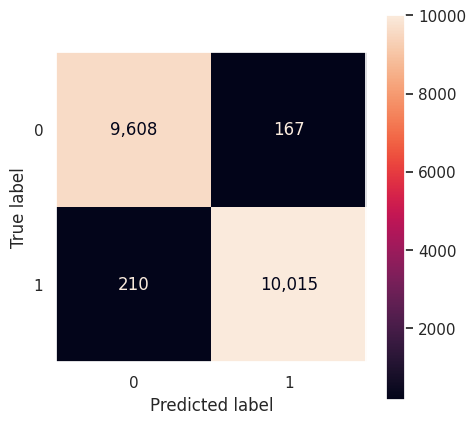

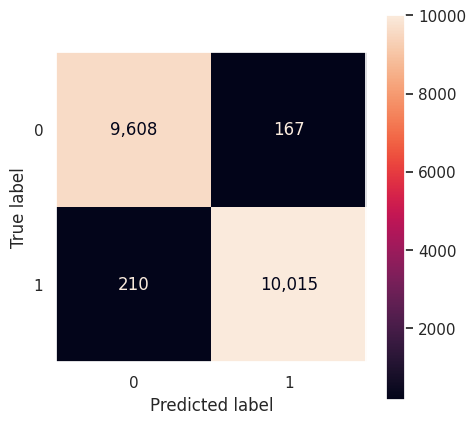

In [81]:
print("Confusion Matrix")
confusion_matrix_heatmap(cm)

In [82]:
print("F1 score:", f1)

F1 score: 0.9815259469789778
